* tflite python docs -> https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python
* Unsure how to use this model - [created an issue due to missing labels](https://github.com/google-coral/edgetpu/issues/29)
* Use the object detection model MobileNet SSD v2 (COCO)
```
Detects the location of 90 types objects
Dataset: COCO
Input size: 300x300
```

In [1]:
import argparse
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import tflite_runtime.interpreter as tflite

In [2]:
all_models_dir = '/home/pi/github/edgetpu/test_data/'

In [3]:
all_models = os.listdir(all_models_dir)

In [4]:
for filename in all_models:
    if 'ssd_v2' in filename:
        print(filename)

mobilenet_ssd_v2_face_quant_postprocess.tflite
mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess.tflite


In [5]:
image = 'images/' + 'people_car.jpg'
# image = all_models_dir + 'parrot.jpg'
image

'images/people_car.jpg'

In [6]:
model_file = all_models_dir + 'mobilenet_ssd_v2_coco_quant_postprocess.tflite'
model_file

'/home/pi/github/edgetpu/test_data/mobilenet_ssd_v2_coco_quant_postprocess.tflite'

In [7]:
label_file = 'MobileNet_SSD_v2_COCO/coco_labels.txt'
label_file

'MobileNet_SSD_v2_COCO/coco_labels.txt'

In [8]:
# Function to read labels from text files.
def ReadLabelFile(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        ret = {}
        for line in lines:
            pair = line.strip().split(maxsplit=1)
            ret[int(pair[0])] = pair[1].strip()
    return ret
    
labels = ReadLabelFile(label_file)

In [9]:
labels

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 12: 'stop sign',
 13: 'parking meter',
 14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 26: 'backpack',
 27: 'umbrella',
 30: 'handbag',
 31: 'tie',
 32: 'suitcase',
 33: 'frisbee',
 34: 'skis',
 35: 'snowboard',
 36: 'sports ball',
 37: 'kite',
 38: 'baseball bat',
 39: 'baseball glove',
 40: 'skateboard',
 41: 'surfboard',
 42: 'tennis racket',
 43: 'bottle',
 45: 'wine glass',
 46: 'cup',
 47: 'fork',
 48: 'knife',
 49: 'spoon',
 50: 'bowl',
 51: 'banana',
 52: 'apple',
 53: 'sandwich',
 54: 'orange',
 55: 'broccoli',
 56: 'carrot',
 57: 'hot dog',
 58: 'pizza',
 59: 'donut',
 60: 'cake',
 61: 'chair',
 62: 'couch',
 63: 'potted plant',
 64: 'bed',
 66: 'dining table',
 69: 'toilet',
 71: 'tv',
 72: 'laptop',
 73: 'mou

In [10]:
len(labels)

80

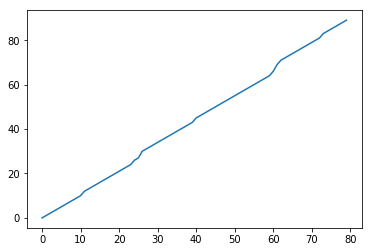

In [11]:
plt.plot(labels.keys())

In [13]:
interpreter = tflite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [14]:
input_details

[{'name': 'normalized_input_image_tensor',
  'index': 260,
  'shape': array([  1, 300, 300,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128)}]

In [15]:
input_details[0]['index']

260

In [16]:
output_details

[{'name': 'TFLite_Detection_PostProcess',
  'index': 252,
  'shape': array([ 1, 20,  4]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 253,
  'shape': array([ 1, 20]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 254,
  'shape': array([ 1, 20]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:3',
  'index': 255,
  'shape': array([1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [17]:
floating_model = input_details[0]['dtype'] == np.float32
floating_model

False

In [18]:
# NxHxWxC, H:1, W:2. Note this is not maintaining aspect ratio
height = input_details[0]['shape'][1]
print(height)
width = input_details[0]['shape'][2]
print(width)
img = Image.open(image).resize((width, height))

300
300


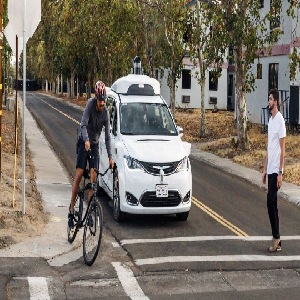

In [19]:
img

In [20]:
# add N dim
input_data = np.expand_dims(img, axis=0)

In [21]:
input_data.shape

(1, 300, 300, 3)

In [22]:
if floating_model:
    input_data = (np.float32(input_data) - input_mean) / input_std

In [23]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = np.squeeze(interpreter.get_tensor(output_details[0]['index']))

CPU times: user 297 ms, sys: 9.16 ms, total: 306 ms
Wall time: 310 ms


In [24]:
output_data.shape

(20, 4)

Need to flatten?

In [25]:
results = output_data.flatten()
print(results.shape)
results

(80,)


array([0.25783607, 0.33058104, 0.72460085, 0.64287066, 0.28432977,
       0.28714725, 0.67880917, 0.378723  , 0.52459025, 0.22533128,
       0.8592638 , 0.35025725, 0.2879002 , 0.256508  , 0.6752387 ,
       0.36057574, 0.3070004 , 0.87134504, 0.81644344, 0.96126306,
       0.35408726, 0.23384929, 0.7558392 , 0.35211307, 0.36449456,
       0.4775374 , 0.42808366, 0.52330697, 0.36257973, 0.43447763,
       0.433535  , 0.47549564, 0.26758716, 0.14137253, 0.30434695,
       0.15388337, 0.8016275 , 0.89876413, 0.84045804, 0.9362016 ,
       0.2724718 , 0.8918469 , 0.8467107 , 0.979772  , 0.2590526 ,
       0.2339508 , 0.7744281 , 0.41370416, 0.3485671 , 0.36448342,
       0.4546207 , 0.39803433, 0.2661516 , 0.06933359, 0.30224597,
       0.09438118, 0.39177337, 0.23829046, 0.7389006 , 0.29629192,
       0.5905774 , 0.16806212, 0.89603657, 0.33539888, 0.29444313,
       0.11302397, 0.6834138 , 0.83335793, 0.19575499, 0.4499519 ,
       0.25171104, 0.47239918, 0.02176804, 0.63939416, 0.39767

Get the index of the top results

In [26]:
top_k = results.argsort()[-5:][::-1]
top_k

array([75, 43, 19, 39, 37], dtype=int32)

In [27]:
for i in top_k:
    if floating_model:
        print('{:08.6f}: {}'.format(float(results[i]), labels[i]))
    else:
        print('{:08.6f}: {}'.format(float(results[i] / 255.0), labels[i]))

0.003903: keyboard
0.003842: bottle
0.003770: sheep
0.003671: baseball glove
0.003525: kite
